In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils import *

import os

In calculating workload, found that some departments in Oakland and DC have typos, overlaps, or are subcategories of each other. The mapping below was based on research in the 311 data portals interfaces and city government websites.

In [6]:
mapframe = pd.DataFrame([
    ('oakland','ROW_STREETSW','ROW'), # ROW = Right of Way. ROW_STREETSW = Right of Way Streets and Sidewalks, subcategory of ROW
    ('washington','TPPA','PPSA'), # both are PPSA, Policy Planning and Sustainability Administration
    ('washington','STREETLI','STREETLIGHT'), # typo of streetlight
    ('washington','SBM POTHOLES STREETT','POTHOLES'),
    ('washington','SBM POTHOLES ALLEY','POTHOLES'),
], columns=['city','department','new_department'])

mapframe

,city,department,new_department
0,oakland,ROW_STREETSW,ROW
1,washington,TPPA,PPSA
2,washington,STREETLI,STREETLIGHT
3,washington,SBM POTHOLES STREETT,POTHOLES
4,washington,SBM POTHOLES ALLEY,POTHOLES


In [17]:
files

['boston_cleaned_1.csv',
 'boston_cleaned_2.csv',
 'buffalo_cleaned.csv',
 'miami_cleaned_1.csv',
 'miami_cleaned_2.csv',
 'oakland_cleaned.csv',
 'washington_dc_cleaned.csv']

In [14]:
files = os.listdir('../data/raw')
cities = set([f.split("_")[0] for f in files])

newtix = []

c = 'miami'
city = pd.DataFrame()
print("loading:",c)
for f in files:
    if c in f:
        tmp = pd.read_csv(
            f"../data/raw/{f}",
            parse_dates=['open_date','close_date'],
        )
        city = pd.concat([city,tmp]).reset_index(drop=True)

loading: miami


In [10]:
files = os.listdir('../data/raw')
cities = set([f.split("_")[0] for f in files])

newtix = []

for c in cities:
    city = pd.DataFrame()
    print("loading:",c)
    for f in files:
        if c in f:
            tmp = pd.read_csv(
                f"../data/raw/{f}",
                parse_dates=['open_date','close_date'],
            )
            city = pd.concat([city,tmp]).reset_index(drop=True)
    city['city'] = c
    city = city.merge(mapframe, on=['city','department'], how='left')
    city.loc[city['new_department'].notna(),'department'] = city.loc[city['new_department'].notna(),'new_department']
    city = time_series_newtix(city, c)
    city.to_csv(f"../data/processed/{c}_newtix.csv", index=False)
    newtix.append(city)

loading: miami
loading: boston
loading: buffalo
loading: washington
loading: oakland


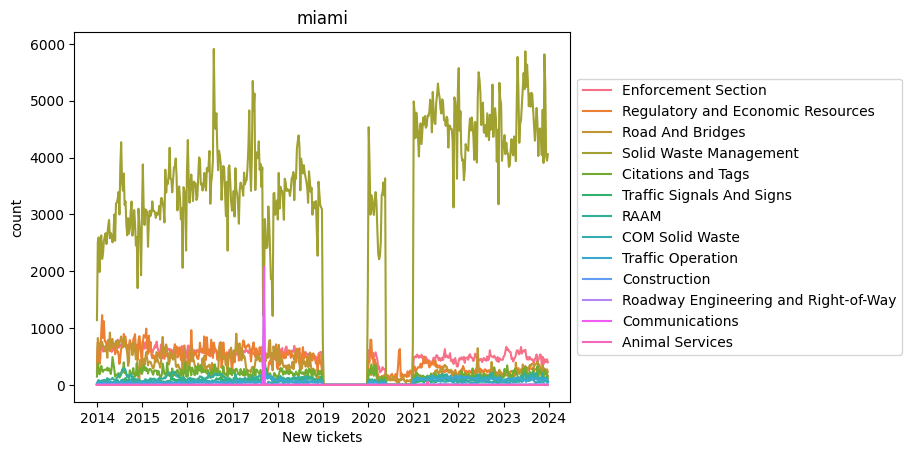

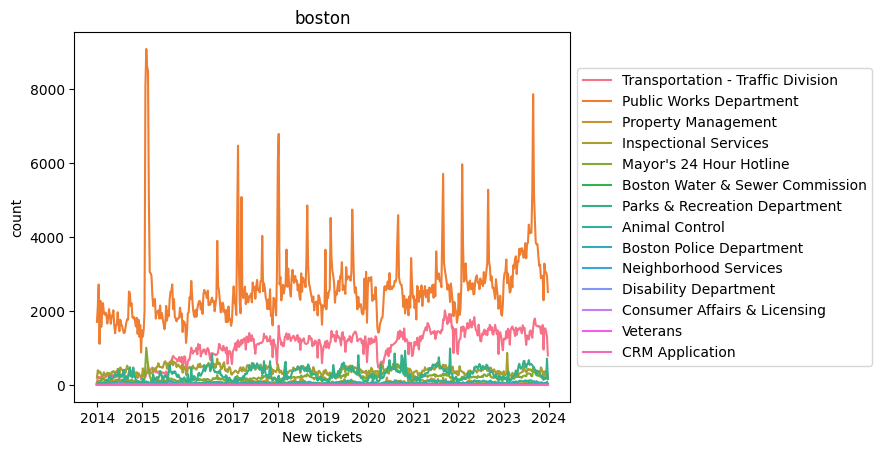

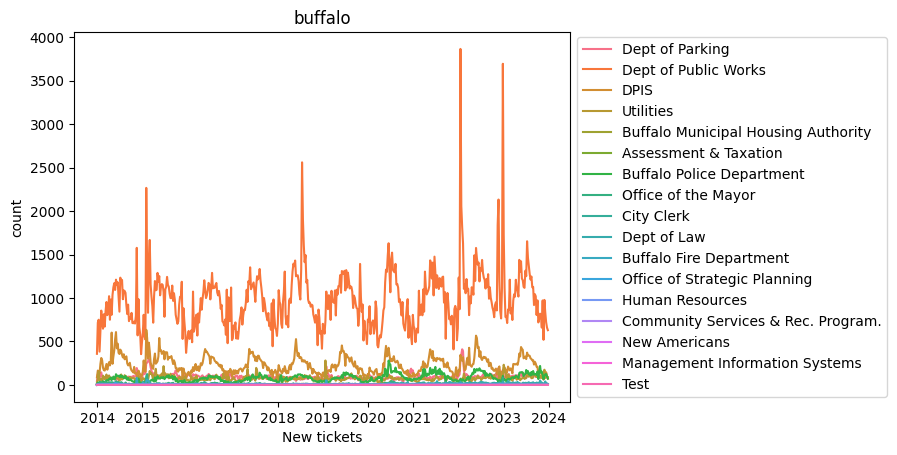

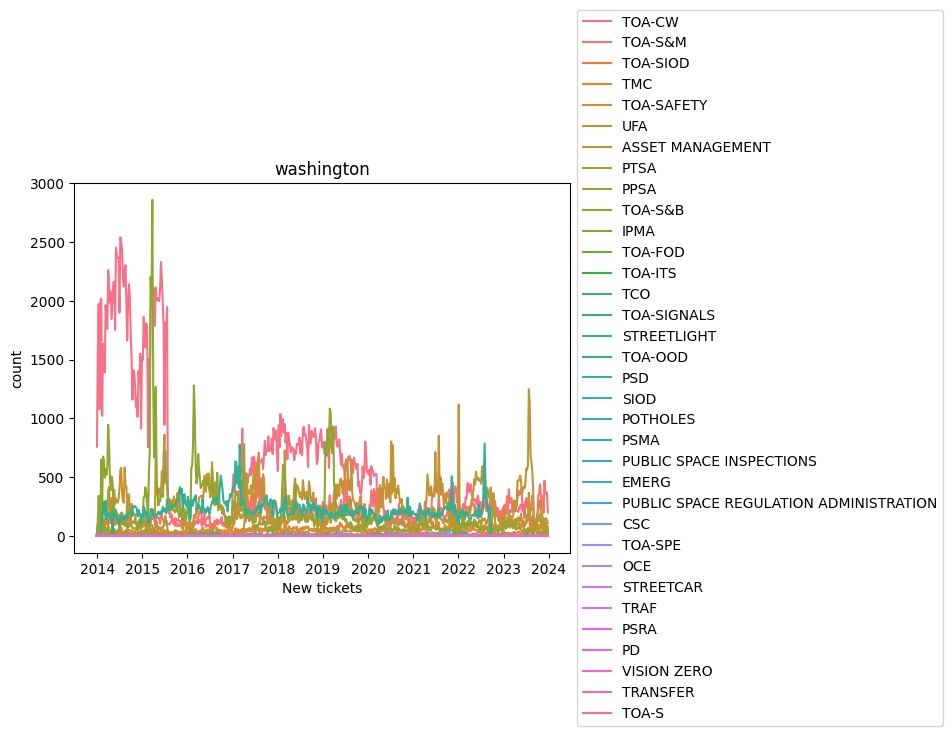

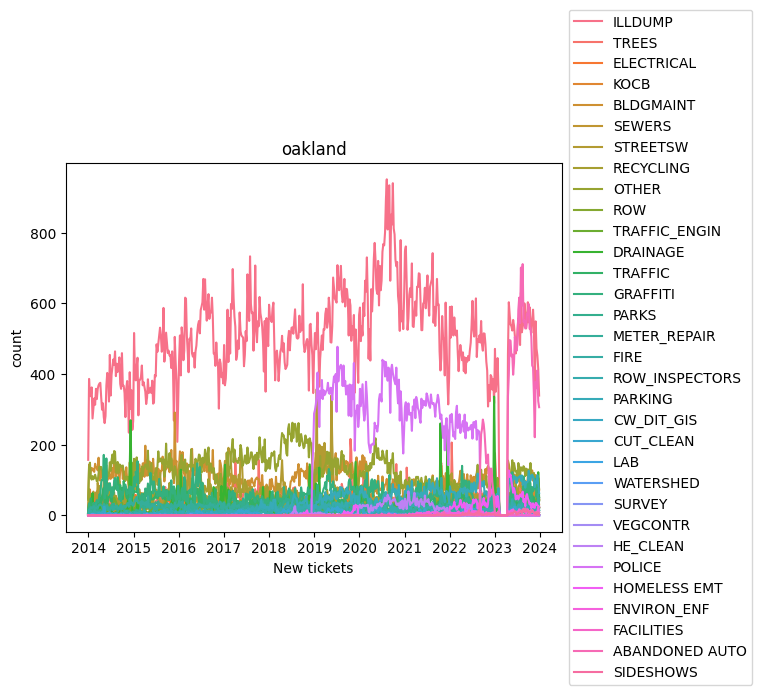

In [12]:
for w in newtix:
    plot = sns.lineplot(data=w, x="week_start", y="count", hue="department")
    plt.title(w['city'].unique()[0])
    plt.xlabel("New tickets")
    plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')
    plt.show()